In [29]:
from medpredictor import Graph, Encoder, Config, Utils
import numpy as np
import pandas as pd
from scipy.stats import randint
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn import metrics
from imblearn.over_sampling import SMOTENC
from IPython.display import Markdown

### **Setting up the dataframe**

In [10]:
df = pd.read_csv(Config.data_cleaned_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  object 
 1   HighBP                253680 non-null  object 
 2   HighChol              253680 non-null  object 
 3   CholCheck             253680 non-null  object 
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  object 
 6   Stroke                253680 non-null  object 
 7   HeartDiseaseorAttack  253680 non-null  object 
 8   PhysActivity          253680 non-null  object 
 9   Fruits                253680 non-null  object 
 10  Veggies               253680 non-null  object 
 11  HvyAlcoholConsump     253680 non-null  object 
 12  AnyHealthcare         253680 non-null  object 
 13  NoDocbcCost           253680 non-null  object 
 14  GenHlth               253680 non-null  object 
 15  

### **Utils**

In [26]:
def model_metrics(y_test, y_pred, average):
    met = {'Accuracy':round((metrics.accuracy_score(y_test, y_pred) * 100), 2),
              'Recall': round((metrics.recall_score(y_test, y_pred, average=average) * 100), 2),
              'Precision': round((metrics.precision_score(y_test, y_pred, average=average) * 100), 2),
              'F1-score': round((metrics.f1_score(y_test, y_pred, average=average) * 100), 2)
              }
    return met

def show_metrics(met):
    for key, value in met.items():
        display(Markdown(f"{key}: **{value}**%"))
    return


### **Feature engineering**

In [12]:
df_enc_dict = {}

df_dec_dict = {}

orders = {}

num_columns = ['BMI', 'MentHlth', 'PhysHlth']

df_copy = df.drop(columns=num_columns)

enc = Encoder()

orders = {'age': Utils.values_age_order,
          'health_status': Utils.values_status_order,
          'income': Utils.values_income_order,
          'education': Utils.values_education_order,
          'diabetes': Utils.values_diabetes_order}

for column in df_copy.columns:
    order = orders.get(column, None)
    if order is not None:
        enc_, dec_ = enc.ordinal_encoder_method(df=df_copy, 
                                          column_name=column, 
                                          order=order)
        df_enc_dict[column] = pd.DataFrame({column + '_enc': enc_})
        df_dec_dict[column] = pd.DataFrame({column + '_dec': dec_})
        continue
    enc_, dec_ = enc.label_encoder_method(df=df_copy,
                                    column_name=column)
    df_enc_dict[column] = pd.DataFrame({column + '_enc': enc_})
    df_dec_dict[column] = pd.DataFrame({column + '_dec': dec_})

df_numerics = enc.robust_scaler_method(df=df, columns_name=num_columns)

df_enc_dict.update({'numerics':df_numerics})

df_enc = pd.concat(list(df_enc_dict.values()), axis=1)
df_dec = pd.concat(list(df_dec_dict.values()), axis=1)

df_enc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Diabetes_012_enc          253680 non-null  int64  
 1   HighBP_enc                253680 non-null  int64  
 2   HighChol_enc              253680 non-null  int64  
 3   CholCheck_enc             253680 non-null  int64  
 4   Smoker_enc                253680 non-null  int64  
 5   Stroke_enc                253680 non-null  int64  
 6   HeartDiseaseorAttack_enc  253680 non-null  int64  
 7   PhysActivity_enc          253680 non-null  int64  
 8   Fruits_enc                253680 non-null  int64  
 9   Veggies_enc               253680 non-null  int64  
 10  HvyAlcoholConsump_enc     253680 non-null  int64  
 11  AnyHealthcare_enc         253680 non-null  int64  
 12  NoDocbcCost_enc           253680 non-null  int64  
 13  GenHlth_enc               253680 non-null  i

In [13]:
X_h1 = df_enc.drop(columns=['MentHlth', 'PhysHlth',
                            'Diabetes_012_enc', 'CholCheck_enc',
                            'AnyHealthcare_enc', 'NoDocbcCost_enc',
                            'Education_enc', 'Income_enc' 
                            ])
y_h1 = df_enc['Diabetes_012_enc']

X_h2 = df_enc.drop(columns=['MentHlth', 'PhysHlth',
                            'Stroke_enc', 'AnyHealthcare_enc',
                            'NoDocbcCost_enc', 'Education_enc',
                            'Income_enc'])
y_h2 = df_enc['Stroke_enc']

X_h3 = df_enc.drop(columns=['MentHlth', 'PhysHlth',
                            'HeartDiseaseorAttack_enc','AnyHealthcare_enc',
                            'NoDocbcCost_enc', 'Education_enc',
                            'Income_enc'])
y_h3 = df_enc['HeartDiseaseorAttack_enc']

### **Hypotesis n° 1**

How do a person's demographic characteristics, habits and physical conditions influence the likelihood of developing diabetes, according to the indicator recorded?

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_h1, y_h1, test_size=0.3, random_state=42)

In [17]:
sm = SMOTENC(categorical_features=list(range(len(X_h1.columns)-1)))
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

#### **K-Nearest Neighbors**

In [19]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

### **Model's metrics**

Accuracy: **74.35**%

Recall: **74.35**%

Precision: **79.71**%

F1-score: **76.72**%

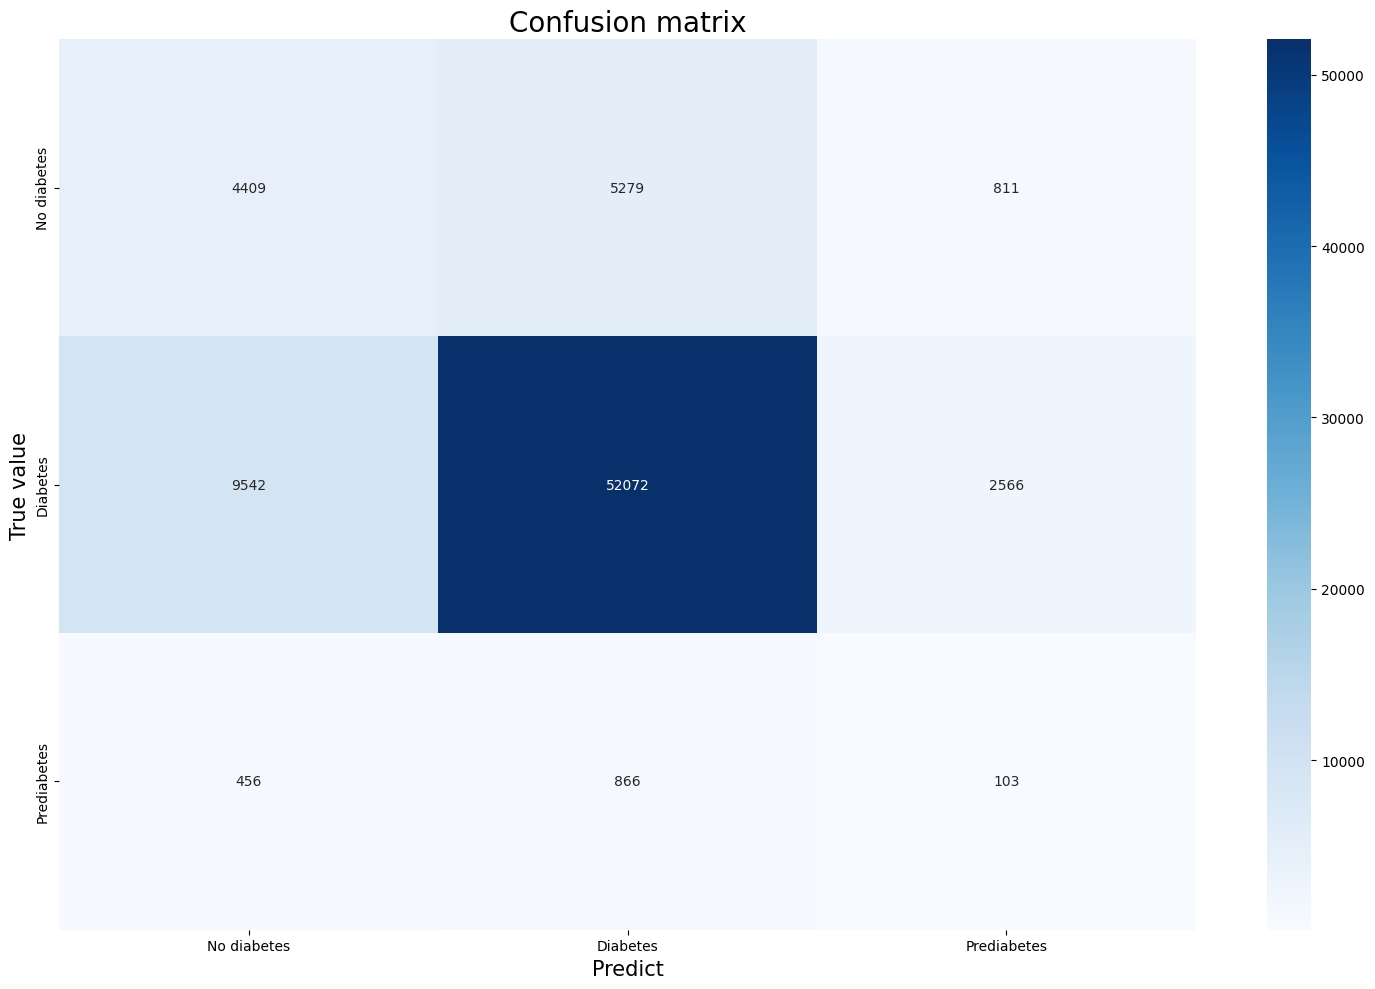

In [27]:
met = model_metrics(y_test, y_pred, 'weighted')
display(Markdown("### **Model's metrics**"))
show_metrics(met)

cm = metrics.confusion_matrix(y_test, y_pred)

title = "Confusion matrix"
x_label = "Predict"
y_label = "True value"
colors = "Blues"

graph = Graph(graph_title=title,
              xlabel_name=x_label,
              ylabel_name=y_label,
              colors=colors)

graph.heatmap_plot_sns(data=cm, 
                       xticklabels=df_dec['Diabetes_012_dec'].unique(),
                       yticklabels=df_dec['Diabetes_012_dec'].unique()
                       )

#### **Random Forest**

In [30]:
param_dist = {'n_estimators': randint(20, 30),
              'max_depth': randint(1,20)}

rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf,
                                 param_distributions=param_dist,
                                 n_iter=5,
                                 cv=5)

rand_search.fit(X_train_resampled, y_train_resampled)

best_rf = rand_search.best_estimator_

display(Markdown(f"Best hyperparameters: {rand_search.best_params_}"))

Best hyperparameters: {'max_depth': 10, 'n_estimators': 27}

Taking into account this hyperparameters, let's train a new Random Forest Classifier

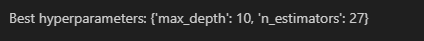

In [31]:
model = RandomForestClassifier(n_estimators=27, 
                               max_depth=10)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

### **Model's metrics**

Accuracy: **65.17**%

Recall: **65.17**%

Precision: **84.58**%

F1-score: **72.2**%

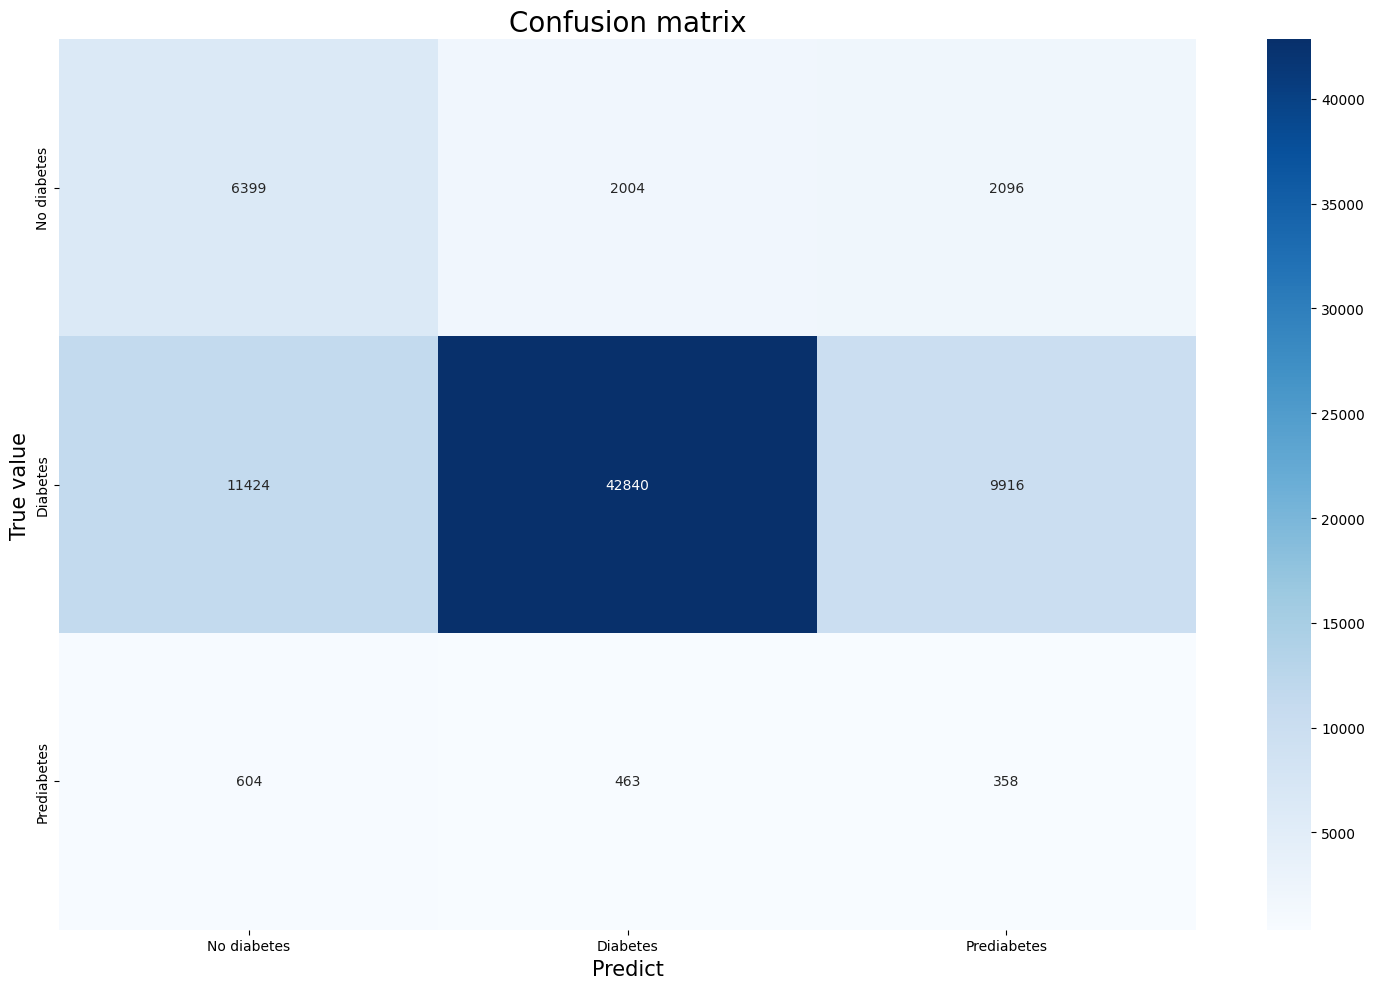

In [32]:
met = model_metrics(y_test, y_pred, 'weighted')
display(Markdown("### **Model's metrics**"))
show_metrics(met)

cm = metrics.confusion_matrix(y_test, y_pred)

title = "Confusion matrix"
x_label = "Predict"
y_label = "True value"
colors = "Blues"

graph = Graph(graph_title=title,
              xlabel_name=x_label,
              ylabel_name=y_label,
              colors=colors)

graph.heatmap_plot_sns(data=cm, 
                       xticklabels=df_dec['Diabetes_012_dec'].unique(),
                       yticklabels=df_dec['Diabetes_012_dec'].unique()
                       )

### **Hypotesis n° 2**

How do a person's demographics, habits and physical conditions influence the likelihood of having a stroke?

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_h2, y_h2, test_size=0.3, random_state=42)

In [37]:
sm = SMOTENC(categorical_features=list(range(len(X_h2.columns)-1)))
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

#### **K-Nearest Neighbors**

In [38]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

### **Model's metrics**

Accuracy: **88.42**%

Recall: **27.32**%

Precision: **11.42**%

F1-score: **16.11**%

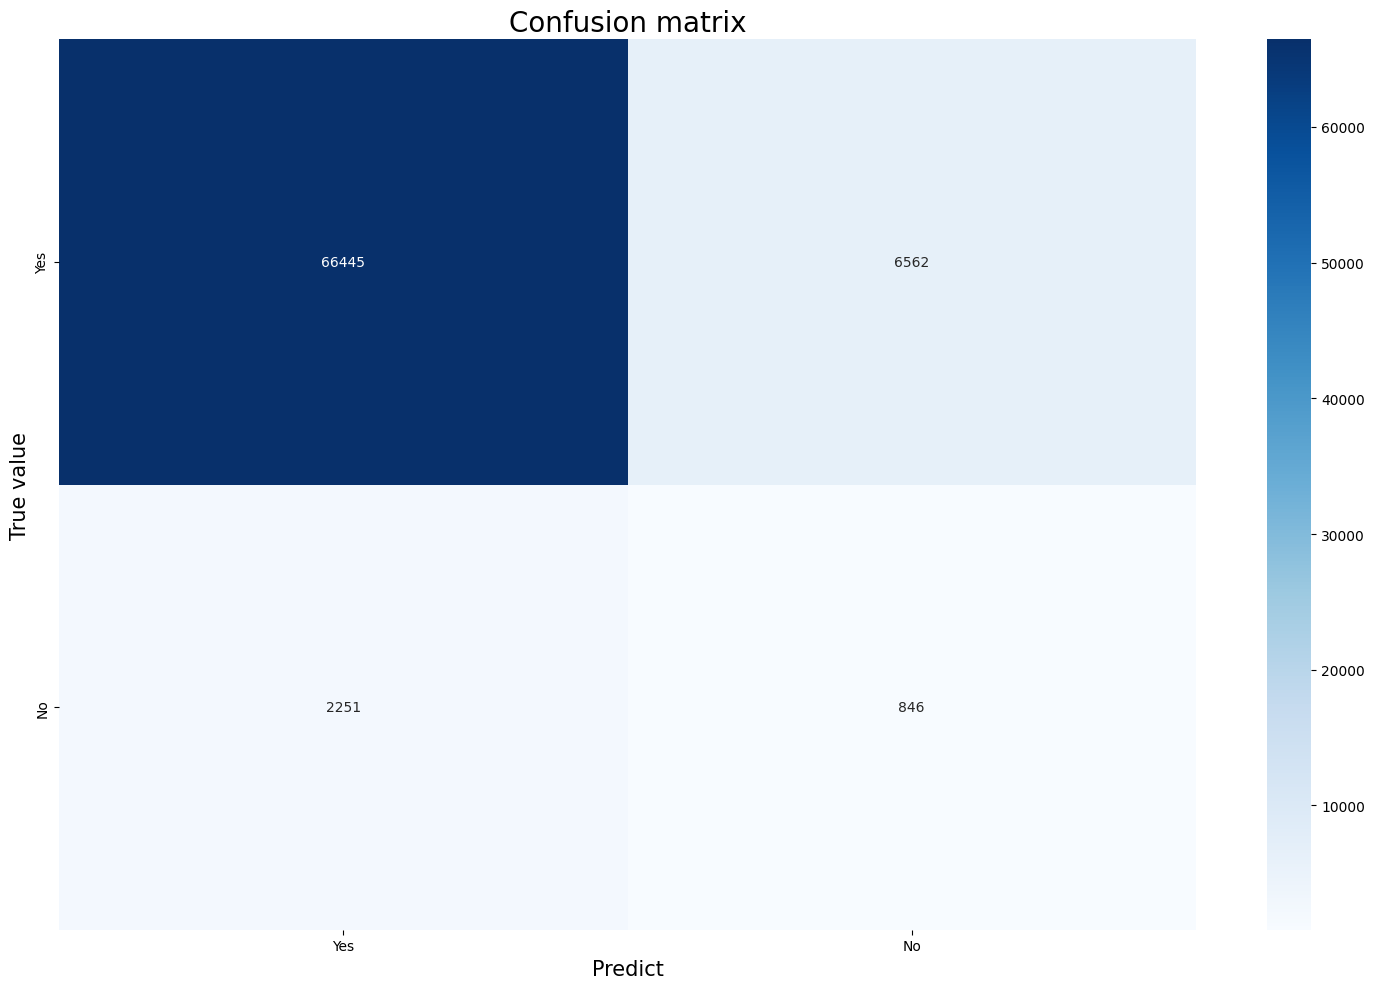

In [40]:
met = model_metrics(y_test, y_pred, 'binary')
display(Markdown("### **Model's metrics**"))
show_metrics(met)

cm = metrics.confusion_matrix(y_test, y_pred)

title = "Confusion matrix"
x_label = "Predict"
y_label = "True value"
colors = "Blues"

graph = Graph(graph_title=title,
              xlabel_name=x_label,
              ylabel_name=y_label,
              colors=colors)

graph.heatmap_plot_sns(data=cm, 
                       xticklabels=['Yes', 'No'],
                       yticklabels=['Yes', 'No']
                       )

#### **Random Forest**

In [41]:
param_dist = {'n_estimators': randint(20, 30),
              'max_depth': randint(1,20)}

rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf,
                                 param_distributions=param_dist,
                                 n_iter=5,
                                 cv=5)

rand_search.fit(X_train_resampled, y_train_resampled)

best_rf = rand_search.best_estimator_

display(Markdown(f"Best hyperparameters: {rand_search.best_params_}"))

Best hyperparameters: {'max_depth': 16, 'n_estimators': 22}

Taking into account this hyperparameters, let's train a new Random Forest Classifier

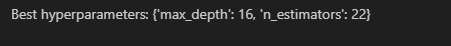

In [43]:
model = RandomForestClassifier(n_estimators=22, 
                               max_depth=16)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

### **Model's metrics**

Accuracy: **80.9**%

Recall: **54.73**%

Precision: **11.43**%

F1-score: **18.91**%

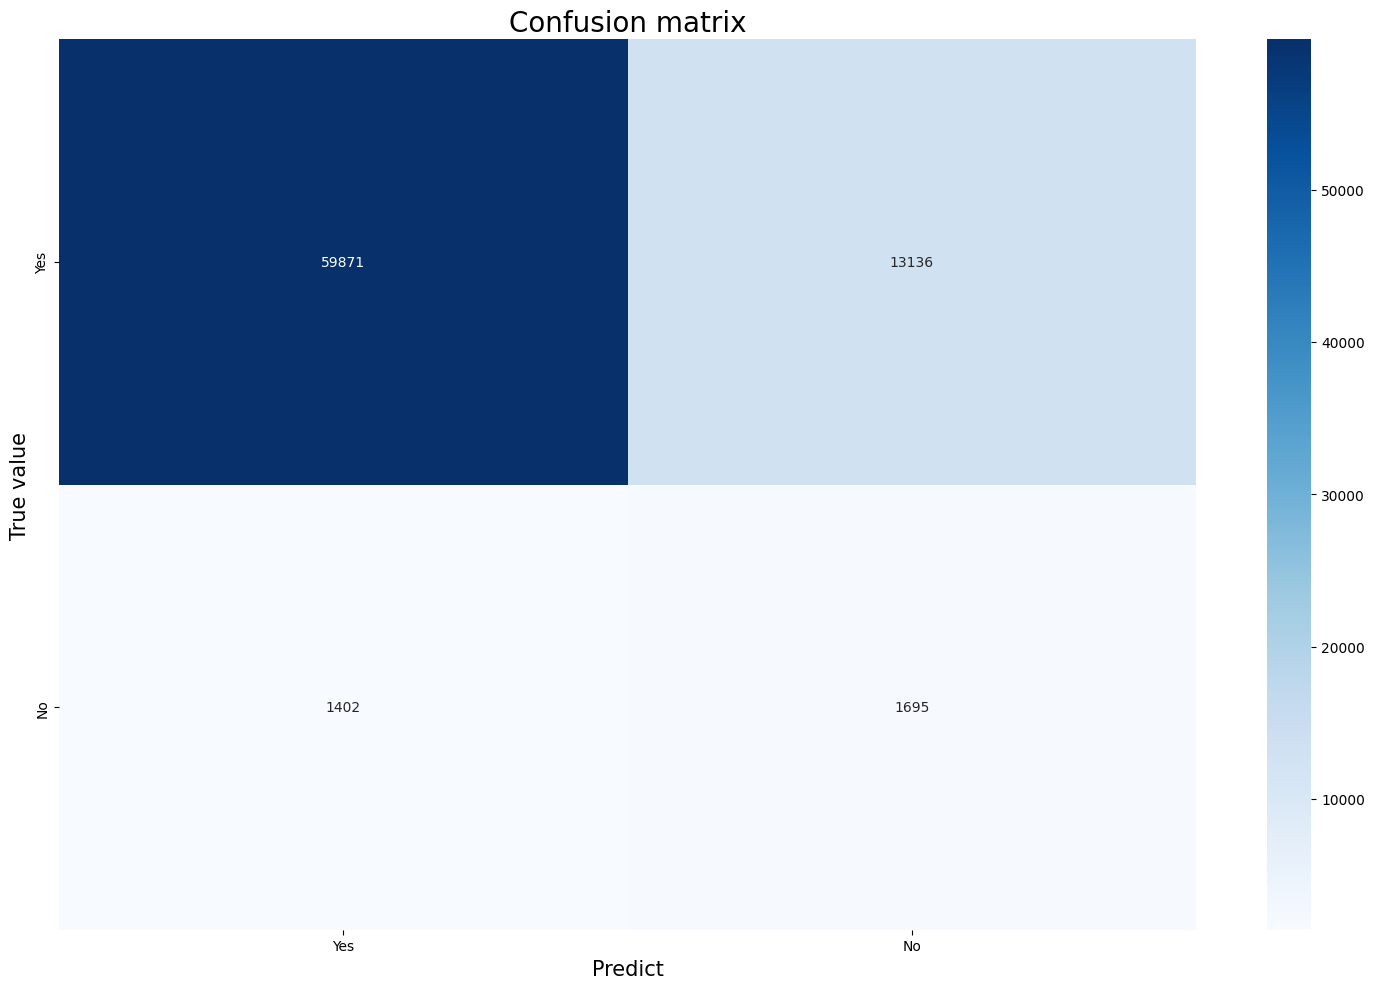

In [44]:
met = model_metrics(y_test, y_pred, 'binary')
display(Markdown("### **Model's metrics**"))
show_metrics(met)

cm = metrics.confusion_matrix(y_test, y_pred)

title = "Confusion matrix"
x_label = "Predict"
y_label = "True value"
colors = "Blues"

graph = Graph(graph_title=title,
              xlabel_name=x_label,
              ylabel_name=y_label,
              colors=colors)

graph.heatmap_plot_sns(data=cm, 
                       xticklabels=['Yes', 'No'],
                       yticklabels=['Yes', 'No']
                       )

#### **Hypotesis n° 3**

How do a person's demographics, habits and physical conditions influence the likelihood of having a heart attack?

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_h3, y_h3, test_size=0.3, random_state=42)

In [46]:
sm = SMOTENC(categorical_features=list(range(len(X_h2.columns)-1)))
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

#### **K-Nearest Neighbors**

In [47]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

### **Model's metrics**

Accuracy: **83.39**%

Recall: **40.26**%

Precision: **25.38**%

F1-score: **31.13**%

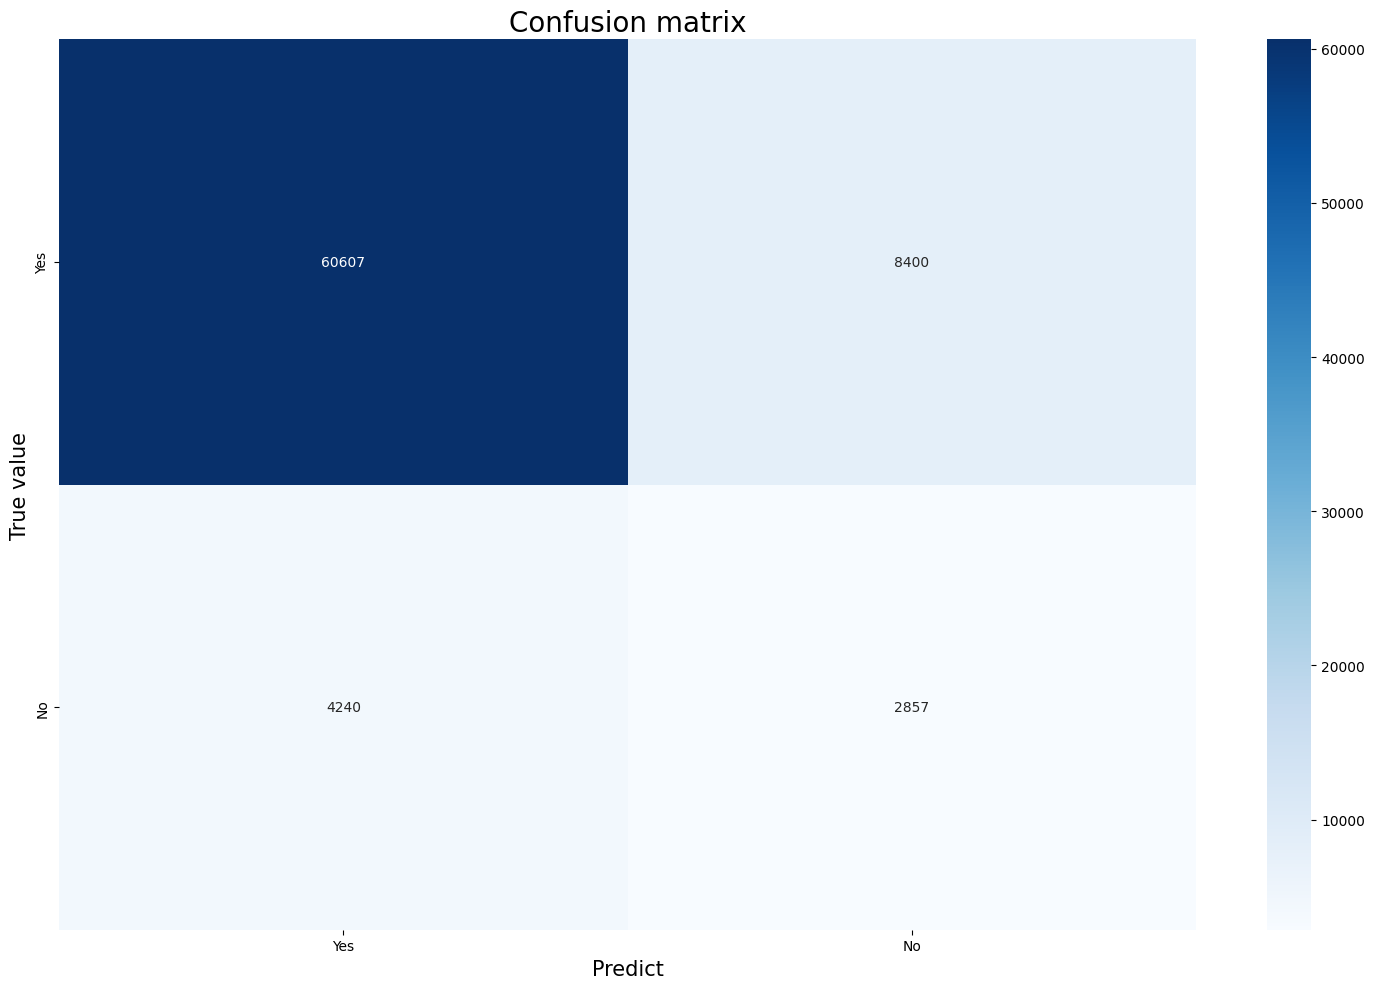

In [48]:
met = model_metrics(y_test, y_pred, 'binary')
display(Markdown("### **Model's metrics**"))
show_metrics(met)

cm = metrics.confusion_matrix(y_test, y_pred)

title = "Confusion matrix"
x_label = "Predict"
y_label = "True value"
colors = "Blues"

graph = Graph(graph_title=title,
              xlabel_name=x_label,
              ylabel_name=y_label,
              colors=colors)

graph.heatmap_plot_sns(data=cm, 
                       xticklabels=['Yes', 'No'],
                       yticklabels=['Yes', 'No']
                       )

#### **Random Forest**

In [49]:
param_dist = {'n_estimators': randint(20, 30),
              'max_depth': randint(1,20)}

rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf,
                                 param_distributions=param_dist,
                                 n_iter=5,
                                 cv=5)

rand_search.fit(X_train_resampled, y_train_resampled)

best_rf = rand_search.best_estimator_

display(Markdown(f"Best hyperparameters: {rand_search.best_params_}"))

Best hyperparameters: {'max_depth': 16, 'n_estimators': 25}

Taking into account this hyperparameters, let-s train a new Random Forest Classifier

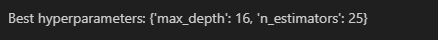

In [50]:
model = RandomForestClassifier(n_estimators=25, 
                               max_depth=16)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

### **Model's metrics**

Accuracy: **78.18**%

Recall: **66.52**%

Precision: **24.91**%

F1-score: **36.25**%

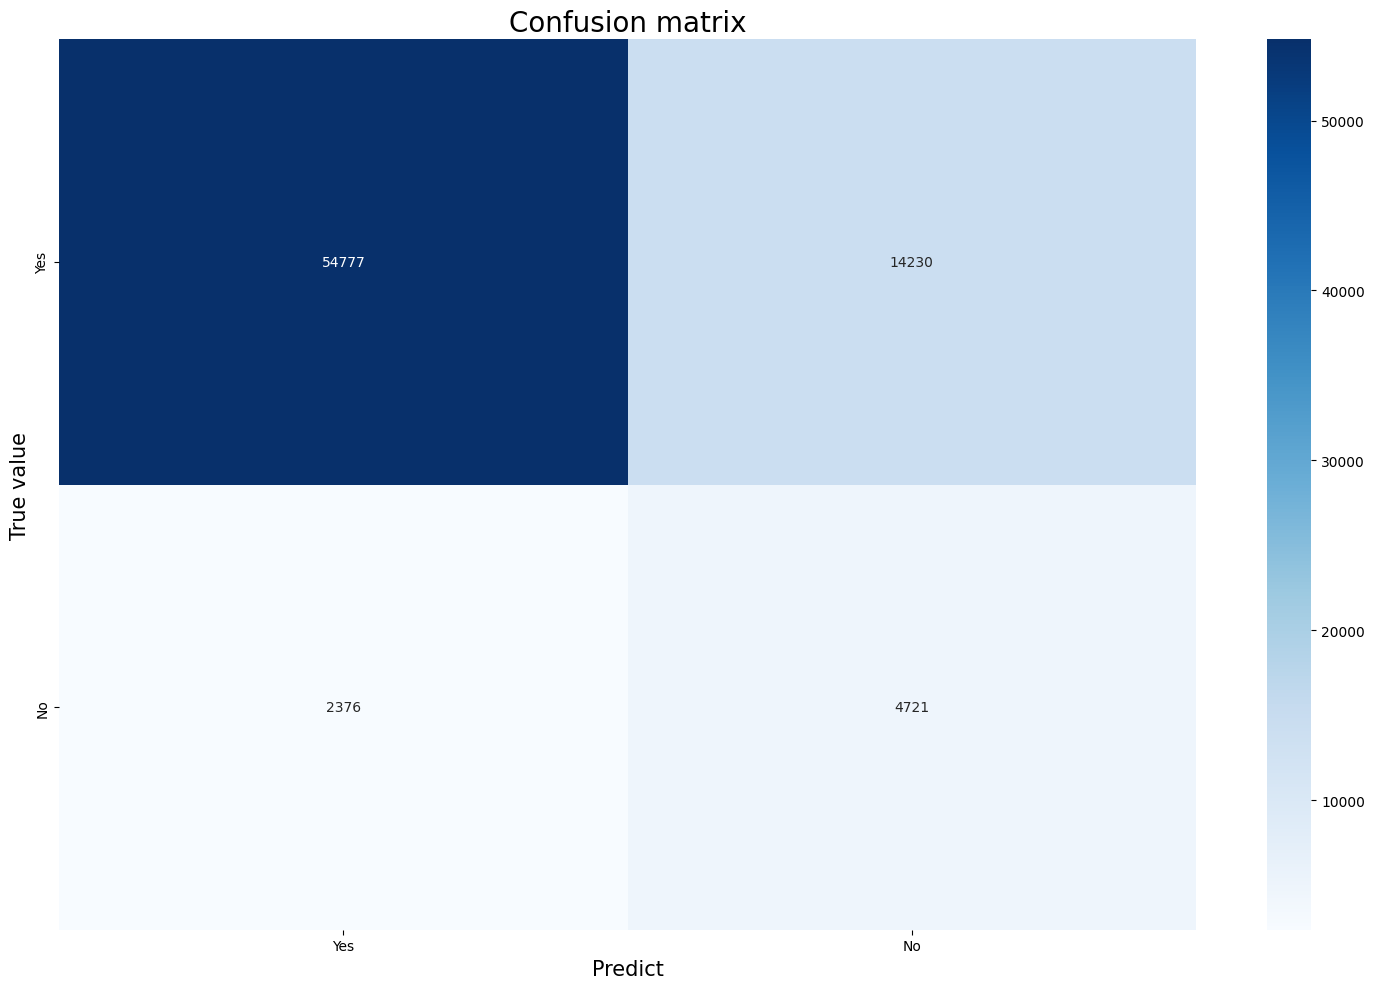

In [51]:
met = model_metrics(y_test, y_pred, 'binary')
display(Markdown("### **Model's metrics**"))
show_metrics(met)

cm = metrics.confusion_matrix(y_test, y_pred)

title = "Confusion matrix"
x_label = "Predict"
y_label = "True value"
colors = "Blues"

graph = Graph(graph_title=title,
              xlabel_name=x_label,
              ylabel_name=y_label,
              colors=colors)

graph.heatmap_plot_sns(data=cm, 
                       xticklabels=['Yes', 'No'],
                       yticklabels=['Yes', 'No']
                       )